### Building Chatbot With Multiple Tools Using Langgraph

#### Aim
Create a chatbot with tool capabilities from arxiv, wikipedia search and some functions

In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [2]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("Attention iss all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [4]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [5]:
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [6]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")



In [7]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

In [9]:
tavily.invoke("Provide me the recent AI news for march 3rd 2025")

[{'url': 'https://medium.com/@abhishekmonpara198/weekly-tech-talk-march-3rd-2025-stay-informed-about-the-most-recent-updates-in-the-industry-4d0f4519891d',
  'content': 'A startup, Akool, upgrades Akool Streaming Avatars by connecting them with AI models and adding advanced video generation tech integrating with large language models (LLMs). According to recently published data from Chinese AI provider Deepseek, AI language models have the potential to generate significant profit margins, even when priced well below that of OpenAI. OpenAI decided to postpone the release of its advanced research model on its API as they assessed the potential risks associated with persuasion and misinformation by the AI. Microsoft released Phi-4 models, which are highly efficient AI models processing text, images, and speech simultaneously using less computing power than other systems. Accenture has introduced new accelerators and capabilities aimed at assisting organizations in expanding their use of g

In [10]:
### Combine all the tools in the list

tools=[arxiv,wiki,tavily]

In [ ]:
## Initialize my LLM model

from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen-qwq-32b")

llm_with_tools=llm.bind_tools(tools)

In [ ]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'call_68f8',
  'type': 'tool_call'}]

In [16]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'call_pms5',
  'type': 'tool_call'}]

In [17]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

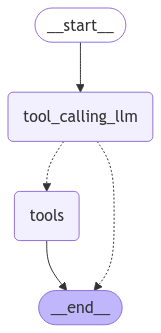

In [18]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [20]:
messages=graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_ymyh)
 Call ID: call_ymyh
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [21]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for MArch 3rd 2025")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for MArch 3rd 2025
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_vfzn)
 Call ID: call_vfzn
  Args:
    query: top 10 recent AI news for March 3rd 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://medium.com/@abhishekmonpara198/weekly-tech-talk-march-3rd-2025-stay-informed-about-the-most-recent-updates-in-the-industry-4d0f4519891d", "content": "A startup, Akool, upgrades Akool Streaming Avatars by connecting them with AI models and adding advanced video generation tech integrating with large language models (LLMs). According to recently published data from Chinese AI provider Deepseek, AI language models have the potential to generate significant profit margins, even when priced well below that of OpenA

In [22]:
messages=graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_31ew)
 Call ID: call_31ew
  Args:
    query: machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
